In [41]:
#используемые библиотеки 

import pandas as pd 
import numpy as np
from datetime import time, datetime
from scipy import optimize
%matplotlib inline

In [40]:
def read_data(fname):
    # Чтение и обработка данных из лог файла
    cols = ['tmp','id','mag1','mag2','mag3','acs1','acs2','acs3','gyro1', 'gyro2', 'gyro3', 'time']
    df = pd.read_csv(fname, names = cols, sep = '\t', skiprows = [0])

    df.drop(['tmp', 'id'], axis = 1, inplace = True)
    df.drop(0, axis = 0, inplace = True)

    df['time'] = df['time'].apply(lambda x: datetime.strptime(x, "    %H %M %S %f"))
    df['dt'] = df['time'] - df['time'].shift(1)
    df['dt'] = df['dt'].apply(lambda x: x.microseconds/1000000)
    for i in range(1,4): df['gyro'+str(i)] = df['gyro'+str(i)].apply(lambda x: float(x))
    return df

## АКС

,mag1,mag2,mag3,acs1,acs2,acs3,gyro1,gyro2,gyro3,time,dt
1,644,605,568,770,547,533,457.0,349.0,439.0,1900-01-01 10:27:30.493,NaN
2,644,605,569,757,541,537,457.0,349.0,439.0,1900-01-01 10:27:30.513,0.02
3,644,604,568,759,545,534,457.0,350.0,439.0,1900-01-01 10:27:30.533,0.02
4,643,605,570,761,544,531,457.0,350.0,439.0,1900-01-01 10:27:30.553,0.02
5,643,604,568,760,548,537,457.0,349.0,439.0,1900-01-01 10:27:30.573,0.02
...,...,...,...,...,...,...,...,...,...,...,...
6210,616,612,601,509,539,786,457.0,346.0,439.0,1900-01-01 10:29:34.681,0.03
6211,616,612,601,511,537,785,457.0,347.0,438.0,1900-01-01 10:29:34.701,0.02
6212,616,613,600,508,538,784,457.0,346.0,438.0,1900-01-01 10:29:34.721,0.02
6213,615,611,600,513,539,788,457.0,347.0,438.0,1900-01-01 10:29:34.731,0.01


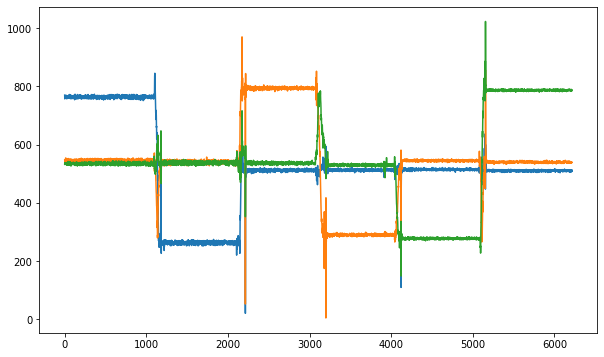

In [42]:
df = read_data('INS-MEMS1.log')

df['acs1'].plot(figsize=(10,6))
df['acs2'].plot()
df['acs3'].plot()
df

In [43]:
def mean(col, t1, t2):    # функция для осреднений значений col на интервале от t1 до t2
    return np.array(df[[col+'1', col+'2', col+'3']][t1:t2].mean())

g = 9.81
t = [[1, 900], [1200, 2000], [2300, 3000], [3300, 4000], [4300, 5000], [5300, 6000]] # интервалы времени 

fz = np.zeros((3, 6)) # создаем массив как матрицу
mean_acs = []
for i in range(6):    # осредняем для всех 6ти граней 
    mean_acs.append(mean('acs', t[i][0], t[i][1])) #по строкам a'
    fz[i//2][i] = g if i % 2 == 0 else -g
mean_acs = np.array(mean_acs).T  # осредненные результаты измерений , уже по столбцам 

In [44]:
def f(S):  # квадратичная функция ошибки, которую нужно минимизировать 
    A = S.reshape((4,3)); b = A[-1]
    A = fz - np.dot(A[:-1], mean_acs) - np.array([b]*6).T
    return np.linalg.norm(A)**2

res = optimize.minimize(f, np.random.rand(12), method='Powell') # численное нахождение минимума
 
S = res.x.reshape((4,3))[:-1]
b = res.x.reshape((4,3))[-1]

print(res.success)
print(S, '\n\n', b)
f(res.x)

True
[[ 3.91494628e-02  5.46252283e-05  3.53877300e-04]
 [-3.71251744e-04  3.89048230e-02  3.76345001e-04]
 [-2.30474384e-04  5.11845338e-04 -3.85026537e-02]] 

 [-20.28246058 -21.10270768  20.38165799]


0.026397478845978126

In [45]:
d = (fz - np.dot(S, mean_acs) - np.array([b]*6).T)
cov = np.cov(d)
P = np.linalg.inv(np.dot(S.T, S))

D = np.sqrt(np.abs(np.dot(cov, np.dot(S.T, S))))
print(D)

[[0.00097775 0.00059136 0.00153865]
 [0.00058528 0.00040584 0.00081354]
 [0.00153419 0.00082666 0.00258254]]


In [25]:
np.abs(D/S)

array([[2.49747410e-02, 1.08113915e+01, 4.34737572e+00],
       [1.57663322e+00, 1.04318184e-02, 2.16225237e+00],
       [6.65645125e+00, 1.61491214e+00, 6.70744141e-02]])

## БЕЗ ПРИВЯЗКИ К КОРПУСУ

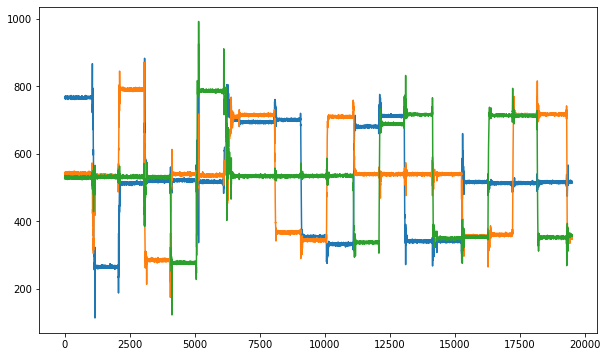

In [76]:
df = read_data('INS-MEMS3.log')

df['acs1'].plot(figsize=(10,6))
df['acs2'].plot()
df['acs3'].plot()

In [78]:

t = [[1, 800], [1200, 1900], [2100, 2850], [3370, 4100], [4300, 5000],[5300, 6000],[6800, 7700],[8100,8800],
     [9200, 9900], [10200, 11000], [11200, 12000], [12200, 12900],[13100, 13800],[14200, 14900],[15350,16000],
     [16500, 16800], [17300, 18000], [18300, 19000]]

g = 9.8

mean_acs = [mean('acs', t[i][0], t[i][1]) for i in range(len(t))]

mean_acs = np.array(mean_acs).T

def triangle(S):
    A = np.zeros((3,3))
    A[0][0] = S[0]; 
    A[1][0] = S[1]; A[1][1] = S[2]; 
    A[2][0] = S[3]; A[2][1] = S[4]; A[2][2] = S[5]
    return A

def f(S):
    b = S[-3:]
    A = np.dot(triangle(S), mean_acs).T
    ans = 0
    for a in A: ans += (g*g - np.linalg.norm(a + b)**2)**2
    return ans
    
S0 = np.array([3.91688703e-02, 2.46257708e-04, 3.88803898e-02, 3.39648272e-05,  2.92157707e-04, -3.84857785e-02,
            -20.09175641, -21.49574248,  20.27100528])
opt = optimize.minimize(f, S0, method='Powell') # численное нахождение минимума

print(opt.success)
print(triangle(opt.x))
print(b)

True
[[ 3.90466513e-02  0.00000000e+00  0.00000000e+00]
 [-1.35790579e-05  3.89714414e-02  0.00000000e+00]
 [-4.02805368e-04  3.77101452e-05 -3.84292725e-02]]
[457.23708709 344.91191191 437.71011011]


## ДУС 

In [65]:
df = read_data('INS-MEMS2.log')

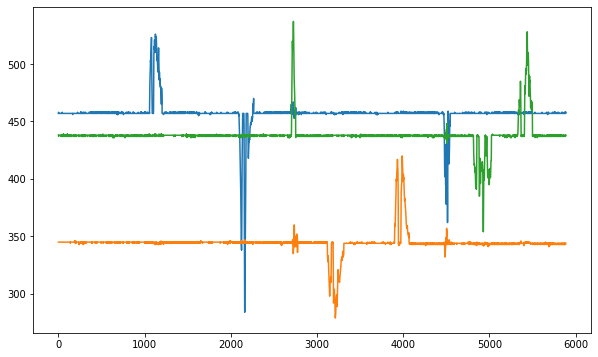

In [66]:
df['gyro1'].plot(figsize=(10,6))
df['gyro2'].plot()
df['gyro3'].plot()

In [79]:
import pandas as pd 
import numpy as np

def integrate(col, t1, t2):
    d = df[[col+'1', col+'2', col+'3', 'dt']][t1:t2]
    return np.array([(d[col+str(i)]*d['dt']).sum()/d['dt'].sum() for i in range(1,4)])

t = [[1050, 1200], [2100, 2300], [2650,2750], [3850, 4050], [4450, 4550], [4900, 5000]] # интервалы времени 

b = integrate('gyro', 0, 1000)

for i in range(3):
    df['b' + str(i+1)] = b[i]
    df['g' + str(i+1)] = df['gyro' + str(i+1)] - df['b' + str(i+1)] # обнуляем показания. 

angle  = np.pi/2
angles = np.zeros((3, 6)) 

phi = []
for i in range(6):
    phi.append(integrate('g', t[i][0], t[i][1]))
    angles[i//2][i] = -angle if i % 2 == 0 else angle #ЛЕвые части для углов
phi = np.array(phi).T




phi = []
for i in range(6):
    phi.append(integrate('g', t[i][0], t[i][1]))
    angles[i//2][i] = -angle if i % 2 == 0 else angle
phi = np.array(phi).T

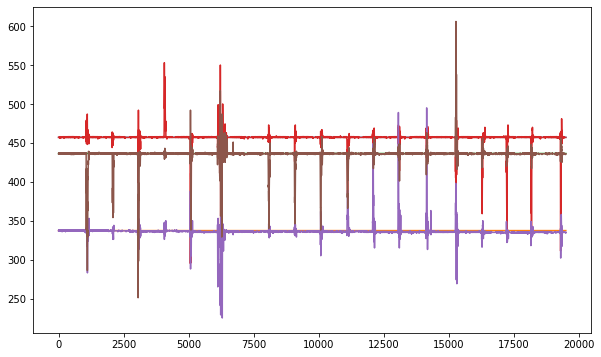

In [80]:
df['b1'].plot(figsize=(10,6))
df['b2'].plot()
df['b3'].plot()

df['gyro1'].plot(figsize=(10,6))
df['gyro2'].plot()
df['gyro3'].plot()

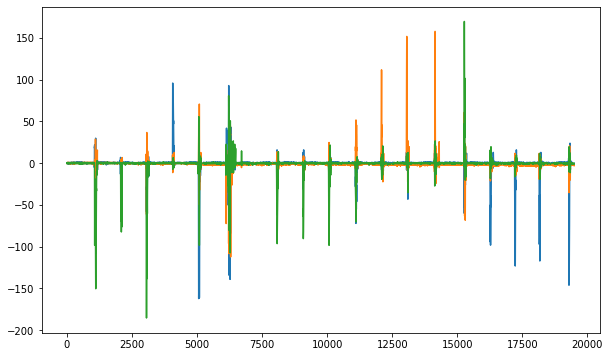

In [81]:
df['g1'].plot(figsize=(10,6))
df['g2'].plot()
df['g3'].plot()

In [82]:


phi -= np.array([b]*6).T

def f(S):  # квадратичная функция ошибки, которую нужно минимизировать 
    A = angles - np.dot(S.reshape(3,3), phi)
    return np.linalg.norm(A)**2

res = optimize.minimize(f, np.random.rand(9))   # численное нахождение минимума

print(res.success)
print(res.x.reshape((3,3)), '\n\n', b)
f(res.x)


False
[[-0.54246723  0.84739422 -0.08831061]
 [ 1.04726521 -1.78403164  0.28364331]
 [ 0.44137416 -0.75088688  0.1187785 ]] 

 [457.1261577  337.29702128 436.361602  ]


8.417752783489565

In [ ]:
def f(S):
    A = S.reshape((4,3))[:-1]; b = S.reshape((4,3))[-1]
    A = np.dot(A, mean_acs).T
    ans = 0
    for a in A: ans += (g*g - np.linalg.norm(a + b)**2)**2
    return ans